# **Customer Lifetime Value (CLTV) Prediction with BG-NBD and Gamma Gamma Models using Online Retail Dataset**

# Business problem

### An e-commerce company wants to divide its customers into groups and show marketing approaches specific to these groups. For this, it wants to divide the customers into groups by using various techniques and to exhibit various approaches specific to these groups.

# Dataset story

### The dataset named Online Retail includes online sales transactions of a UK-based retail company between 01/12/2009 and 09/12/2011. The company's product catalog includes souvenirs and it is known that most of its customers are wholesalers.¶

* InvoiceNo: Invoice Number (If this code starts with C, it means that the transaction has been cancelled)
* StockCode: Product code (unique for each product)
* Description: Product name
* Quantity: Number of products (How many of the products on the invoices were sold)
* InvoiceDate: Invoice date
* UnitPrice: Invoice price ( Sterling )
* CustomerID: Unique customer number
* Country: Country name

# Let's import the libraries

In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import GammaGammaFitter, BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Let's import the dataset

In [3]:
df_ = pd.read_excel('/kaggle/input/online-retail-dataset/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = df_.copy()
df.columns = [col.lower() for col in df.columns]
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


# Let's prepare the data

### Let's see the missing values

In [4]:
df.isnull().sum().sort_values(ascending=False)

customer id    135080
description      1454
invoice             0
stockcode           0
quantity            0
invoicedate         0
price               0
country             0
dtype: int64

### Since there are missing data, let's remove them from the dataset

In [5]:
df.dropna(inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,406830.000,12.061,248.693,-80995.000,2.000,5.000,12.000,80995.000
price,406830.000,3.461,69.315,0.000,1.250,1.950,3.750,38970.000
customer id,406830.000,15287.684,1713.603,12346.000,13953.000,15152.000,16791.000,18287.000


### In this dataset, the returned products are marked with 'C' in the variable invoice. They must be removed from the dataset. Let's fix this

In [6]:
df = df[~df['invoice'].str.contains('C', na=False)]

### The variables price and quantitiy must be bigger than 0. Let's fix this

In [7]:
df = df[(df['quantity'] > 0)]
df = df[(df['price'] > 0)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,397885.000,12.988,179.332,1.000,2.000,6.000,12.000,80995.000
price,397885.000,3.117,22.098,0.001,1.250,1.950,3.750,8142.750
customer id,397885.000,15294.417,1713.144,12346.000,13969.000,15159.000,16795.000,18287.000


### Let's see the outliers before supressing the outliers

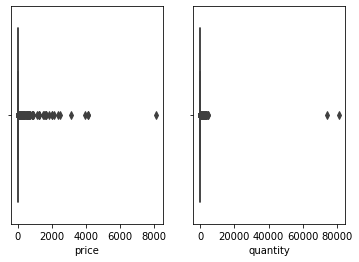

In [8]:
plt.subplot(1, 2, 1)
sns.boxplot(x = df['price'])
plt.subplot(1, 2, 2)
sns.boxplot(x = df['quantity'])
plt.show(block=True)

### Let's replace outliers with thresholds determined

In [9]:
# supressing the outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)
    
replace_with_thresholds(df, 'quantity')
replace_with_thresholds(df, 'price')

### Let's check again the outliers

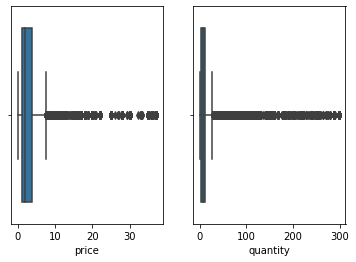

In [10]:
plt.subplot(1, 2, 1)
sns.boxplot(x = df['price'])
plt.subplot(1, 2, 2)
sns.boxplot(x = df['quantity'])
plt.show(block=True)

### Therefore, a significant part of the outliers were removed from the dataset

### Let's create the variable 'total_price'

In [11]:
df['total_price'] = df['quantity'] * df['price']
df

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.100,12680.000,France,12.600
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.950,12680.000,France,14.850


### Let's define the analysis day for 2 days after

In [12]:
df['invoicedate'].max()
today_date = dt.datetime(2011, 12, 11)

# Let's prepare the lifetime data structure

### Recency, tenure, frequency and monetary

In [13]:
cltv_df = df.groupby('customer id').agg(
    {'invoicedate': [lambda invoicedate: (invoicedate.max() - invoicedate.min()).days,
        lambda invoicedate: (today_date - invoicedate.min()).days],
    'invoice': lambda invoice: invoice.nunique(),
    'total_price': lambda total_price: total_price.sum()})
cltv_df

invoicedate             invoice total_price
             <lambda_0> <lambda_1> <lambda>    <lambda>
customer id                                            
12346.000             0        326        1     309.920
12347.000           365        368        7    4310.000
12348.000           282        359        4    1770.240
12349.000             0         19        1    1491.600
12350.000             0        311        1     331.400
...                 ...        ...      ...         ...
18280.000             0        278        1     180.600
18281.000             0        181        1      80.820
18282.000           118        127        2     178.050
18283.000           333        338       16    2094.880
18287.000           158        202        3    1837.280

[4338 rows x 4 columns]

### There is hierarchical index problem in the output. Let's solve this problem

In [14]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
customer id,,,,
12346.000,0,326,1,309.920
12347.000,365,368,7,4310.000
12348.000,282,359,4,1770.240
12349.000,0,19,1,1491.600
12350.000,0,311,1,331.400
...,...,...,...,...
18280.000,0,278,1,180.600
18281.000,0,181,1,80.820
18282.000,118,127,2,178.050


### Let's assign the varibale names as recency, tenure, frequency and monetary

In [15]:
cltv_df.columns = ['recency', 'tenure', 'frequency', 'monetary']
cltv_df

,recency,tenure,frequency,monetary
customer id,,,,
12346.000,0,326,1,309.920
12347.000,365,368,7,4310.000
12348.000,282,359,4,1770.240
12349.000,0,19,1,1491.600
12350.000,0,311,1,331.400
...,...,...,...,...
18280.000,0,278,1,180.600
18281.000,0,181,1,80.820
18282.000,118,127,2,178.050


### Let's convert the data to the type requested by the model

In [16]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']
cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['tenure'] = cltv_df['tenure'] / 7
cltv_df

,recency,tenure,frequency,monetary
customer id,,,,
12347.000,52.143,52.571,7,615.714
12348.000,40.286,51.286,4,442.560
12352.000,37.143,42.429,8,219.468
12356.000,43.143,46.571,3,937.143
12358.000,21.286,21.571,2,575.030
...,...,...,...,...
18272.000,34.857,35.286,6,513.097
18273.000,36.429,36.857,3,68.000
18282.000,16.857,18.143,2,89.025


# Let's establish the BG-NBD model

In [17]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['tenure'])
bgf

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

### Let's get 10 customers with the most expected purchases in a week

In [18]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure']).sort_values(ascending=False).head(10)
# or
# bgf.predict(1, 
#     cltv_df['frequency'], 
#     cltv_df['recency'], 
#     cltv_df['tenure']).sort_values(ascending=False).head(10)

customer id
12748.000   3.250
14911.000   3.126
17841.000   1.940
13089.000   1.537
14606.000   1.464
15311.000   1.434
12971.000   1.357
14646.000   1.206
13408.000   0.986
18102.000   0.969
dtype: float64

### Let's add the expected purchases in a week into the dataframe cltv_df

In [19]:
cltv_df['expected_purch_1_week'] = bgf.predict(1, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure'])
cltv_df

,recency,tenure,frequency,monetary,expected_purch_1_week
customer id,,,,,
12347.000,52.143,52.571,7,615.714,0.141
12348.000,40.286,51.286,4,442.560,0.092
12352.000,37.143,42.429,8,219.468,0.182
12356.000,43.143,46.571,3,937.143,0.086
12358.000,21.286,21.571,2,575.030,0.122
...,...,...,...,...,...
18272.000,34.857,35.286,6,513.097,0.172
18273.000,36.429,36.857,3,68.000,0.104
18282.000,16.857,18.143,2,89.025,0.136


### Let's get 10 customers with the most expected purchases in a month

In [20]:
bgf.predict(1 * 4, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure']).sort_values(ascending=False).head(10)

cltv_df['expected_purch_1_month'] = bgf.predict(1 * 4, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure'])
cltv_df

,recency,tenure,frequency,monetary,expected_purch_1_week,expected_purch_1_month
customer id,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564
12348.000,40.286,51.286,4,442.560,0.092,0.367
12352.000,37.143,42.429,8,219.468,0.182,0.727
12356.000,43.143,46.571,3,937.143,0.086,0.344
12358.000,21.286,21.571,2,575.030,0.122,0.486
...,...,...,...,...,...,...
18272.000,34.857,35.286,6,513.097,0.172,0.686
18273.000,36.429,36.857,3,68.000,0.104,0.416
18282.000,16.857,18.143,2,89.025,0.136,0.539


### Let's reach the number of sales expected by the company in a 3-month period

In [21]:
bgf.predict(4 * 3, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure']).sum()

cltv_df['expected_purch_3_month'] = bgf.predict(3 * 4, 
    cltv_df['frequency'], 
    cltv_df['recency'], 
    cltv_df['tenure'])
cltv_df

,recency,tenure,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_purch_3_month
customer id,,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564,1.678
12348.000,40.286,51.286,4,442.560,0.092,0.367,1.092
12352.000,37.143,42.429,8,219.468,0.182,0.727,2.163
12356.000,43.143,46.571,3,937.143,0.086,0.344,1.022
12358.000,21.286,21.571,2,575.030,0.122,0.486,1.439
...,...,...,...,...,...,...,...
18272.000,34.857,35.286,6,513.097,0.172,0.686,2.037
18273.000,36.429,36.857,3,68.000,0.104,0.416,1.235
18282.000,16.857,18.143,2,89.025,0.136,0.539,1.593


### Let's evaluate the succes of the prediction results

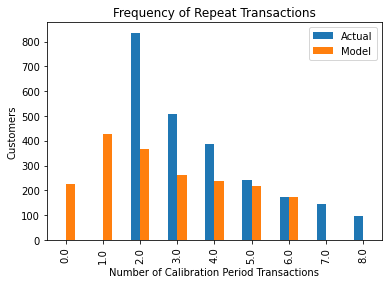

In [22]:
plot_period_transactions(bgf)
plt.show(block=True)

# Let's establish the Gamma Gamma model

In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
ggf

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

### Let's reach the conditional_expected_averege profit values

In [24]:
ggf.conditional_expected_average_profit(
    cltv_df['frequency'], cltv_df['monetary']).head()

customer id
12347.000   631.912
12348.000   463.605
12352.000   224.810
12356.000   995.998
12358.000   631.705
dtype: float64

### Let's reach the conditional_expected_averege profit values in the ascending order

In [25]:
ggf.conditional_expected_average_profit(
    cltv_df['frequency'], 
    cltv_df['monetary']).sort_values(ascending=False).head()

customer id
12415.000   5771.632
12590.000   5029.205
12435.000   4288.941
12409.000   3918.811
14088.000   3917.106
dtype: float64

### Let's save the conditional_expected_averege profit values in the ascending order into the dataframe cltv_df

In [26]:
cltv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(
    cltv_df['frequency'], 
    cltv_df['monetary'])
cltv_df

,recency,tenure,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_purch_3_month,expected_average_profit
customer id,,,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564,1.678,631.912
12348.000,40.286,51.286,4,442.560,0.092,0.367,1.092,463.605
12352.000,37.143,42.429,8,219.468,0.182,0.727,2.163,224.810
12356.000,43.143,46.571,3,937.143,0.086,0.344,1.022,995.998
12358.000,21.286,21.571,2,575.030,0.122,0.486,1.439,631.705
...,...,...,...,...,...,...,...,...
18272.000,34.857,35.286,6,513.097,0.172,0.686,2.037,529.018
18273.000,36.429,36.857,3,68.000,0.104,0.416,1.235,73.494
18282.000,16.857,18.143,2,89.025,0.136,0.539,1.593,99.525


# Let's calculate the cltv using BG-NBD and GG models

In [27]:
cltv = ggf.customer_lifetime_value(bgf, 
                                cltv_df['frequency'], 
                                cltv_df['recency'], 
                                cltv_df['tenure'], 
                                cltv_df['monetary'], 
                                time = 3, # 3 months
                                freq = 'W',  # frequency iformation of tenure in weekly
                                discount_rate = 0.01)

cltv.sort_values(ascending=False)

customer id
14646.000   55735.470
18102.000   47379.080
14096.000   29061.237
12415.000   27682.481
14911.000   27376.165
               ...   
17912.000       0.905
15332.000       0.701
16725.000       0.550
15107.000       0.395
17850.000       0.000
Name: clv, Length: 2845, dtype: float64

### There is an index problem in the output yielded. Let's fix this

In [28]:
cltv = cltv.reset_index()
cltv

,customer id,clv
0,12347.000,1128.447
1,12348.000,538.645
2,12352.000,517.324
3,12356.000,1083.090
4,12358.000,966.370
...,...,...
2840,18272.000,1146.205
2841,18273.000,96.565
2842,18282.000,168.594
2843,18283.000,505.512


# Let's create final dataframe

In [29]:
cltv_final = cltv_df.merge(cltv, on ='customer id', how='left')
cltv_final.sort_values(by='clv', ascending=False).head()

,customer id,recency,tenure,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_purch_3_month,expected_average_profit,clv
1122,14646.000,50.429,50.714,73,3645.708,1.206,4.812,14.334,3654.447,55735.470
2761,18102.000,52.286,52.571,60,3857.012,0.969,3.864,11.511,3868.262,47379.080
843,14096.000,13.857,14.571,17,3163.542,0.729,2.896,8.553,3196.389,29061.237
36,12415.000,44.714,48.286,21,5723.761,0.380,1.514,4.508,5771.632,27682.481
1257,14911.000,53.143,53.429,201,691.679,3.126,12.472,37.164,692.295,27376.165


# Let's create segements according to 'clv'

In [30]:
cltv_final['segment'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'C', 'B', 'A'])
cltv_final.sort_values(by='clv', ascending=False)

,customer id,recency,tenure,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_purch_3_month,expected_average_profit,clv,segment
1122,14646.000,50.429,50.714,73,3645.708,1.206,4.812,14.334,3654.447,55735.470,A
2761,18102.000,52.286,52.571,60,3857.012,0.969,3.864,11.511,3868.262,47379.080,A
843,14096.000,13.857,14.571,17,3163.542,0.729,2.896,8.553,3196.389,29061.237,A
36,12415.000,44.714,48.286,21,5723.761,0.380,1.514,4.508,5771.632,27682.481,A
1257,14911.000,53.143,53.429,201,691.679,3.126,12.472,37.164,692.295,27376.165,A
...,...,...,...,...,...,...,...,...,...,...,...
2682,17912.000,7.714,52.143,5,62.202,0.001,0.004,0.013,65.211,0.905,D
1447,15332.000,0.429,52.857,4,415.265,0.000,0.001,0.002,435.072,0.701,D
2100,16725.000,9.857,53.143,7,111.574,0.000,0.002,0.005,114.957,0.550,D
1346,15107.000,8.714,53.286,6,53.250,0.001,0.002,0.007,55.476,0.395,D


### Let's define a function named 'decision_process'

In [31]:
def decision_process(dataframe, target, variable):
    print(dataframe.groupby(target).agg({variable: ['mean', 'count', 'sum']}))

num_cols = [col for col in cltv_final.columns if cltv_final[col].dtypes not in ['bool', 'category', 'object']]
num_cols = [col for col in num_cols if 'customer id' not in col]
for col in num_cols:
    print('--'*15)
    decision_process(cltv_final, 'segment', col)

------------------------------
        recency                
           mean count       sum
segment                        
D        22.074   712 15716.571
C        30.670   711 21806.143
B        29.515   711 20985.000
A        31.411   711 22333.143
------------------------------
        tenure                
          mean count       sum
segment                       
D       40.465   712 28811.000
C       38.111   711 27097.000
B       34.812   711 24751.143
A       34.484   711 24518.143
------------------------------
        frequency            
             mean count   sum
segment                      
D           3.065   712  2182
C           4.096   711  2912
B           5.442   711  3869
A          11.359   711  8076
------------------------------
        monetary                 
            mean count        sum
segment                          
D        183.954   712 130975.032
C        271.689   711 193170.895
B        373.434   711 265511.521
A        659.805   71

# **Thanks for checking my notebook!**